핸즈온 3장 분류

p.127-154

# [Chapter 3] 분류

## 3.1 MNIST

- MNIST : 70000개의 숫자 이미지 데이터셋
  - 특성 : 0(흰색)부터 255(검은색)까지의 픽셀 강도, 784개

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

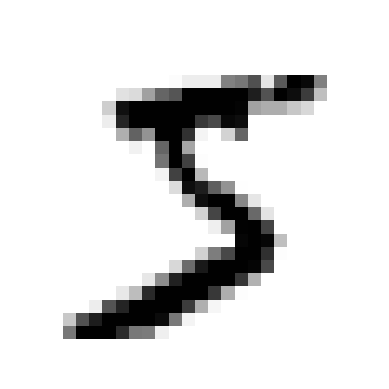

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

- 레이블이 문자열이므로 y를 정수로 변환

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

- 이진 분류기 : 두 개의 클래스를 구분할 수 있는 분류기
- SGDClassifier : 확률적 경사 하강법(Stochastic Gradient Descent) 분류기
  - 장점 : 매우 큰 데이터셋을 효율적으로 처리
  - 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

In [12]:
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

- 이미지가 5를 나타낸다고 추측

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

- 아래 코드는 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력함
- StratifiedKFold : 클래스별 비율이 유지되도록 계층적 샘플링을 통해 폴드 생성
  - 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련, 테스트 폴드로 예측한 뒤, 올바른 예측의 수를 세어 정확한 예측의 비율 출력

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


- cross_val_score()
  - k 교차 검증 : 훈련 세트를 k개 폴드로 나누고, 나머지 폴드로 훈련시킨 모델을 각 폴드를 예측, 평가하기 위해 사용

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 교차 검증 폴드에 대해 정확도가 95% 이상

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

- 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 생성

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 이미지의 10% 정도가 숫자 5이기 때문에 무조건 '5 아님'으로 예측 시, 정확히 맞출 확률이 90%가 됨
- 정확도는 분류기의 성능 지표로 선호하지 않음(특히 불균형한 데이터셋)

### 3.3.2 오차 행렬

- 오차 행렬
  - 행 : 실제 클래스
  - 열 : 예측한 클래스
- cross_val_predict() : k 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측 반환

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 1행 1열 '53892' : 5가 아닌 이미지를 5가 아니라고 맞게 분류 -> true negative
- 1행 2열 '687' : 5가 아닌 이미지를 5라고 잘못 분류 -> false positive
- 2행 1열 '1891' : 5 이미지를 5가 아니라고 잘못 분류 -> false negative
- 2행 2열 '3530': 5 이미지를 5라고 맞게 분류 -> true positive




In [ ]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 완벽한 분류기라면 -> 오차행렬의 주대각선 제외하고 모두 0임

### 3.3.3 정밀도와 재현율

- 정밀도(precision) : 양성 예측의 정확도, TP / (TP+FP)
- 재현율(recall) : 분류기가 정확하게 감지한 양성 샘플의 비율, TP / (TP+FN)

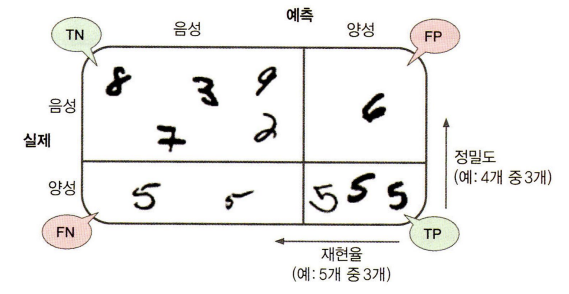

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

- F1 점수 : 정밀도와 재현율의 조화 평균


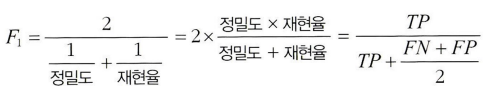

- 정밀도와 재현율이 비슷하면 -> F1 점수가 높음

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

- 정밀도/재현율 트레이드오프 : 정밀도를 올리면 재현율이 줄고, 그 반대도 마찬가지
  - 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산하고 임곗값과 비교하여 클래스에 할당
  - 임곗값을 조정함에 따라 정밀도와 재현율이 달라짐

- decision_function() : 각 샘플의 점수를 얻을 수 있음

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임곗값을 8000으로 높이면 y_scores < threshold 가 되므로 False 반환
- 따라서 임곗값을 높이면 재현율이 줄어듦

- cross_val_predict() : method = "desicion_function"로 지정하여 예측 결과가 아니라 결정 점수를 반환받도록 지정

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44247 (\N{HANGUL SYLLABLE GYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

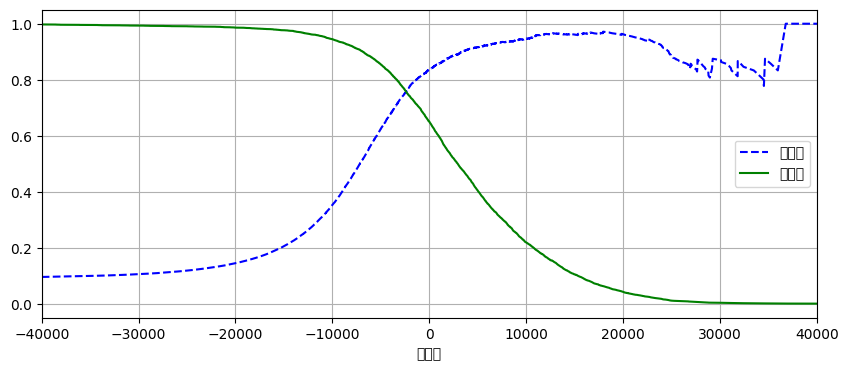

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.figure(figsize=(10,4))
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  plt.xlabel("임곗값")
  plt.xlim(-40000, 40000)
  plt.legend()
  plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 파란색 : 정밀도
- 초록색 : 재현율

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

- np.argmax() : 최댓값의 첫 번째 인덱스 반환
- 정밀도 최소한 90%가 되는 가장 낮은 임곗값 찾기

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선

ROC 곡선 : 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)의 곡선
  - 민감도(재현율)에 대한 1-특이도 그래프
  - 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남
  - 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 함  
   (점선 : 완전한 랜덤 분류기의 ROC 곡선)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

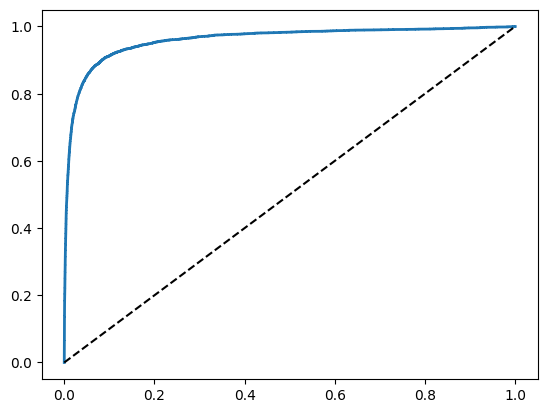

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

AUC : area under the curve
- 완벽한 분류기 : AUC = 1
- 완전한 랜덤 분류기 : AUC = 0.5

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

- RandomForestClassifier에는 decision_function()이 없으므로 predict_proba() 사용
- predict_proba() : 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

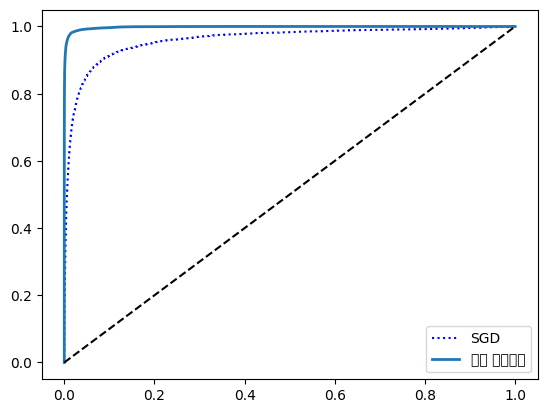

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

- 랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

[정리]
- 일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선 사용, 그렇지 않으면 ROC 곡선 사용

## 3.4 다중 분류

- 다중 분류기 : 둘 이상의 클래스 구별 가능


- OvR 전략(or OvA) : 이진 분류기 여러 개를 훈련시켜 두개 이상의 클래스를 분류
  - 대부분의 이진 분류 알고리즘이 OvR 선호
- OvO 전략 : 각 숫자의 조합마다 이진 분류기 훈련
  - SVM 같은 일부 알고리즘은 훈련 세트의 크기에 민감, 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빨라 OvO 선호

In [9]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 내부에서 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택

In [10]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

- decision_function()을 호출하면 샘플당 10개의 점수 반환

In [15]:
np.argmax(some_digit_scores)

5

In [16]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [17]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR 사용을 강제하려면 아래 클래스 사용
- OneVsOneClassifier
- OneVsRestClassifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [21]:
len(ovr_clf.estimators_)

10

In [18]:
sgd_clf.fit(X_train[:2000], y_train[:2000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [19]:
sgd_clf.decision_function([some_digit])

array([[-1704540.26918897, -1683382.42678916, -2594122.50571131,
         -145667.7337014 , -3270741.36924448,    -4883.95058744,
        -3420127.24409032, -1846510.16554943, -1328858.01006284,
        -2043246.17459117]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

모델의 성능 향상시키는 방법 -> 에러의 종류를 분석

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

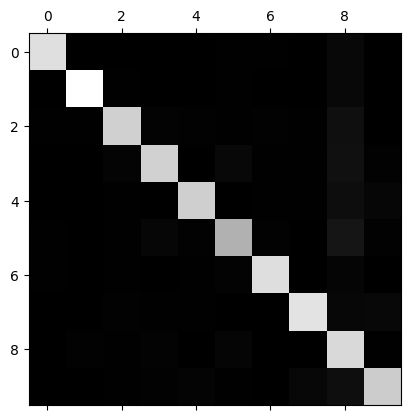

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 배열에서 가장 큰 값은 흰색, 가장 작은 값은 검은색으로 정규화되어 그려짐

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

- 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교

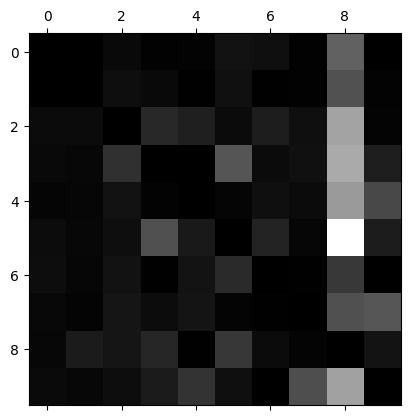

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 행 : 실제 클래스
- 열 : 예측한 클래스

- 클래스 8의 열이 밝으므로 많은 이미지가 8로 잘못 분류되었음을 알 수 있음
- but 클래스 8의 행을 보면 실제 8이 적절히 8로 분류됨

In [34]:
import matplotlib.pyplot as plt
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

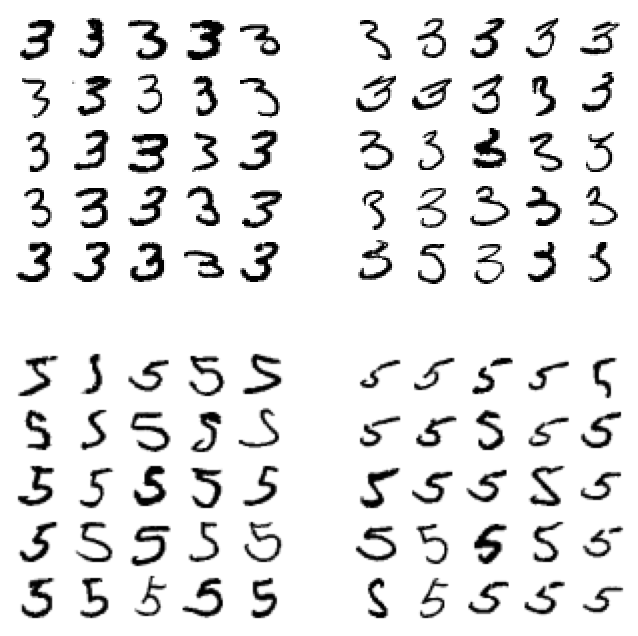

In [35]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽 블록 두 개 : 3으로 분류된 이미지
- 오른쪽 블록 두 개 : 5로 분류된 이미지

- 선형 분류기: 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산

  -> 선형 모델인 SGDClassifier를 사용하면 몇 개의 픽셀만 다른 3과 5를 쉽게 혼동하게 됨

## 3.6 다중 레이블 분류

- 다중 레이블 분류 : 여러 개의 이진 꼬리표를 출력하는 분류 시스템
- KNeighborsClassifier : 다중 레이블 분류 지원

In [38]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [39]:
knn_clf.predict([some_digit])

array([[False,  True]])

- 레이블이 2개 출력
- 5는 7보다 작고(False), 홀수임(True)

In [42]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 다중 레이블 분류기 평가 -> 모든 레이블에 대한 F1 점수의 평균 계산
- average="weighted" : 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 주는 방법

## 3.7 다중 출력 분류

- 다중 출력 (다중 클래스) 분류 : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(값을 2개 이상 가질 수 있음)

In [46]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [47]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

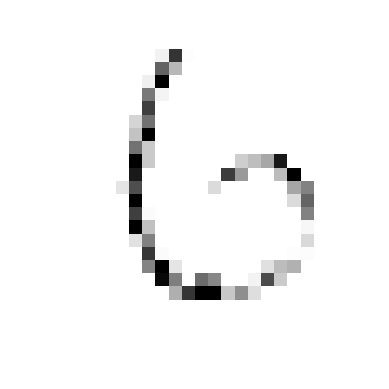

In [48]:
some_index = 100
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

- 분류기를 훈련시켜 잡음이 섞인 입력 이미지를 깨끗하게 만듦